# 🚀 Model Training: ResNet18 Transfer Learning

**Project:** German Traffic Sign Recognition Benchmark (GTSRB)  
**Goal:** Train a Deep Learning model to classify 43 traffic sign categories with high accuracy (>95%).

### 🧠 Methodology
Instead of training a small CNN from scratch, we employ **Transfer Learning** using **ResNet18**.
1.  **Architecture:** ResNet18 (Pre-trained on ImageNet).
2.  **Adaptation:** We modify the first layer to accept $32 \times 32$ images without aggressive downsampling and replace the final classification head to output 43 classes.
3.  **Regularization:** We use Data Augmentation (Rotation, Color Jitter), Weight Decay, and Dropout to prevent overfitting.
4.  **Optimization:** Adam Optimizer with a Step Learning Rate Scheduler.

In [1]:
import sys
import os
import time
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# 1. Setup Project Path
project_root = str(Path.cwd().parent.resolve())
if project_root not in sys.path:
    sys.path.append(project_root)

from src.dataset import GTSRBDataset
from src.model import GTSRBNet

# 2. Device Configuration
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"✅ Training on device: {DEVICE}")

✅ Training on device: mps


## 1. Configuration & Reproducibility
To ensure our results are reproducible (scientifically valid), we lock the random seeds for Python, NumPy, and PyTorch.

In [2]:
# --- Configuration ---
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2
SHUFFLE_DATASET = True
RANDOM_SEED = 42
NUM_EPOCHS = 15
LEARNING_RATE = 0.001

# Paths
DATA_DIR = '../data/GTSRB'
CSV_PATH = f'{DATA_DIR}/Train.csv'

def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"🌱 Random seed set to {seed}")

set_seed(RANDOM_SEED)

🌱 Random seed set to 42


## 2. Data Pipeline & Augmentation
Deep Learning models are data-hungry. To make our model robust to real-world conditions (lighting, camera angles), we apply **Data Augmentation** to the training set.

* **Training Transforms:** Random Rotation, Affine Shifts, Color Jitter.
* **Validation Transforms:** Clean resizing and normalization only (to act as a fair benchmark).

In [3]:
# --- Define Transformations ---

# Training: Augmentation to prevent overfitting
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    # Normalize with ImageNet mean/std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation: No augmentation
val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Create Datasets ---
# We instantiate the dataset twice: once for training (augmented) and once for validation (clean)
train_dataset = GTSRBDataset(csv_file=CSV_PATH, root_dir=DATA_DIR, transform=train_transform, use_roi=True)
val_dataset   = GTSRBDataset(csv_file=CSV_PATH, root_dir=DATA_DIR, transform=val_transform, use_roi=True) # Ensure ROI is used for consistency

# --- Split Indices ---
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))

if SHUFFLE_DATASET:
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# --- Create Loaders ---
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=2)

print(f"📊 Training Samples: {len(train_indices)} | Validation Samples: {len(val_indices)}")

📊 Training Samples: 31368 | Validation Samples: 7841


## 3. Visual Verification
Before training, we visualize a batch of data to confirm:
1.  The ROI cropping is working.
2.  The Augmentation (rotation/color) is being applied correctly to the training set.

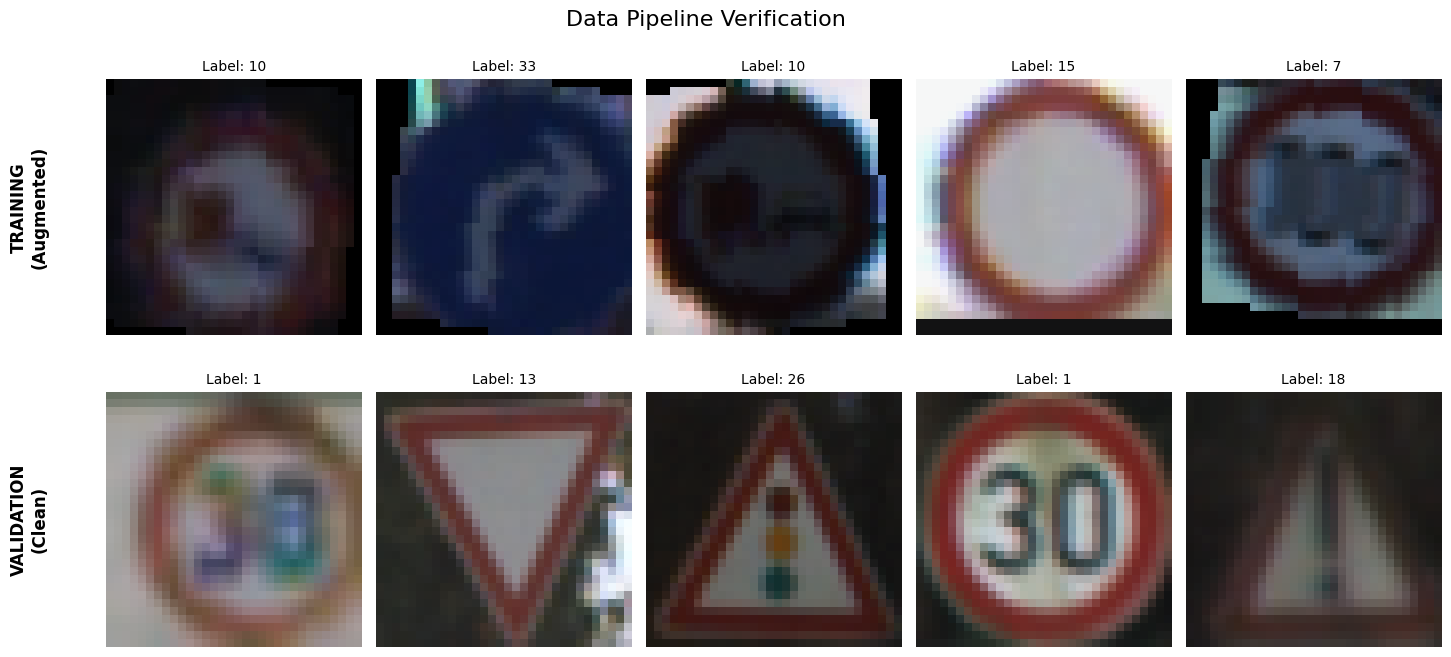

In [5]:
def imshow(img, ax, title):
    """Helper to un-normalize and display an image on a specific axis"""
    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# 1. Get a batch from Training (Should be Augmented)
train_iter = iter(train_loader)
train_images, train_labels = next(train_iter)

# 2. Get a batch from Validation (Should be Clean)
val_iter = iter(val_loader)
val_images, val_labels = next(val_iter)

# 3. Plot them side-by-side
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Add row labels for clarity
axes[0, 0].text(-0.3, 0.5, "TRAINING\n(Augmented)", transform=axes[0, 0].transAxes, 
                ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)
axes[1, 0].text(-0.3, 0.5, "VALIDATION\n(Clean)", transform=axes[1, 0].transAxes, 
                ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)

for i in range(5):
    # Top Row: Training Images
    imshow(train_images[i], axes[0, i], title=f"Label: {train_labels[i].item()}")
    
    # Bottom Row: Validation Images
    imshow(val_images[i], axes[1, i], title=f"Label: {val_labels[i].item()}")

plt.suptitle("Data Pipeline Verification", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(left=0.1) # Make room for the row labels
plt.show()

## 4. Model & Optimization Strategy
We initialize the **ResNet18** model.
* **Loss Function:** `CrossEntropyLoss` (Standard for multi-class classification).
* **Optimizer:** `Adam` (Adaptive Moment Estimation) for fast convergence.
* **Scheduler:** `StepLR`. We decay the learning rate by a factor of 0.1 every 5 epochs. This helps the model "settle" into the global minimum as training progresses.

In [6]:
# 1. Initialize Model
model = GTSRBNet(num_classes=43).to(DEVICE)

# 2. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# 3. Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("✅ Model initialized and ready for training.")

Loading pre-trained ResNet18 weights...
✅ Model initialized and ready for training.


## 5. Training Loop
We iterate through the dataset for `NUM_EPOCHS`.
* **Checkpointing:** We save the model weights (`gtsrb_best_model.pth`) *only* when the Validation Accuracy improves. This ensures we don't save an overfitted model at the very end.

In [7]:
best_acc = 0.0
train_losses, val_losses = [], []
val_accuracies = []

print(f"🚀 Starting Training for {NUM_EPOCHS} epochs...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    epoch_val_loss = val_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_acc)
    
    # --- LOGGING & CHECKPOINT ---
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Val Acc: {epoch_acc:.2f}%")
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), '../models/gtsrb_best_model.pth')
        print(f"   🎉 New best model saved! ({best_acc:.2f}%)")
        
    # Step the scheduler
    scheduler.step()

total_time = time.time() - start_time
print(f"\n🏁 Training finished in {total_time/60:.2f} minutes.")

🚀 Starting Training for 15 epochs...
Epoch [1/15] | Train Loss: 0.3046 | Val Loss: 0.0456 | Val Acc: 98.56%
   🎉 New best model saved! (98.56%)
Epoch [2/15] | Train Loss: 0.0580 | Val Loss: 0.0122 | Val Acc: 99.54%
   🎉 New best model saved! (99.54%)
Epoch [3/15] | Train Loss: 0.0532 | Val Loss: 0.0569 | Val Acc: 98.50%
Epoch [4/15] | Train Loss: 0.0409 | Val Loss: 0.0888 | Val Acc: 97.47%
Epoch [5/15] | Train Loss: 0.0417 | Val Loss: 0.0149 | Val Acc: 99.54%
Epoch [6/15] | Train Loss: 0.0095 | Val Loss: 0.0029 | Val Acc: 99.94%
   🎉 New best model saved! (99.94%)
Epoch [7/15] | Train Loss: 0.0038 | Val Loss: 0.0022 | Val Acc: 99.95%
   🎉 New best model saved! (99.95%)
Epoch [8/15] | Train Loss: 0.0037 | Val Loss: 0.0012 | Val Acc: 99.99%
   🎉 New best model saved! (99.99%)
Epoch [9/15] | Train Loss: 0.0021 | Val Loss: 0.0016 | Val Acc: 99.96%
Epoch [10/15] | Train Loss: 0.0021 | Val Loss: 0.0017 | Val Acc: 99.99%
Epoch [11/15] | Train Loss: 0.0014 | Val Loss: 0.0017 | Val Acc: 99.97%


## 6. Performance Analysis
We plot the Training vs. Validation Loss to diagnose the model's performance.
* **Good Fit:** Training and Validation loss decrease together.
* **Overfitting:** Training loss goes down, but Validation loss starts going up.

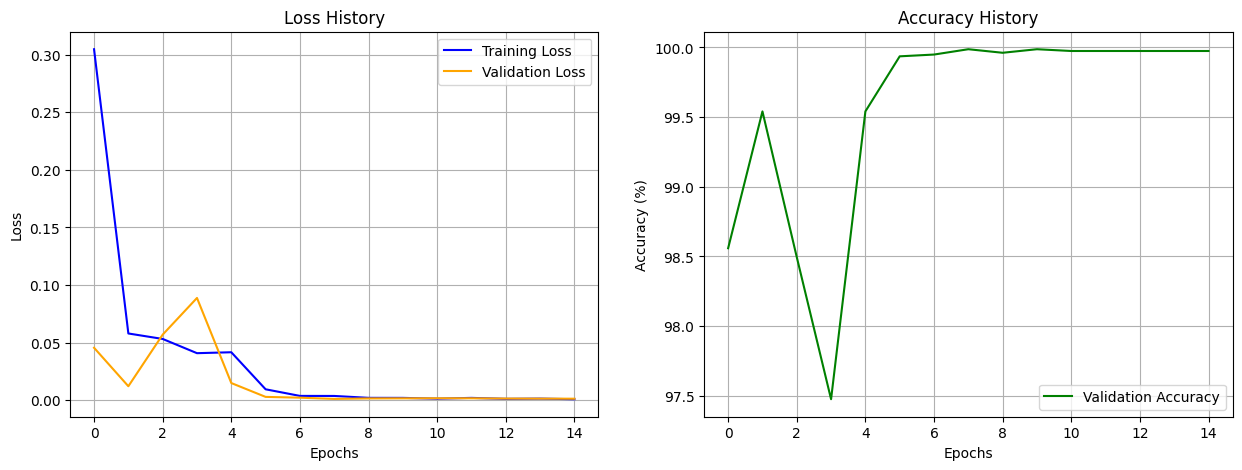

In [8]:
plt.figure(figsize=(15, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Accuracy History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()